# Aplicaciones a Problemas Directos 

**Por:** David Ortiz, Rodrigo Salas

**Edición:** David Ortiz, Tabita Catalán, Tomás Banduc

### Introducción
Continuando con nuestro trabajo previo con PINNs en modelos no lineales, esta actividad amplía nuestra exploración hacia ecuaciones diferenciales parciales (EDPs) utilizando PINNs. Nos centraremos en la solución de un modelo de difusión lineal, específicamente la ecuación de calor en 1D, para examinar cómo las PINNs pueden aplicarse a problemas lineales más simples y profundizar en nuestra comprensión de su adaptabilidad a diferentes tipos de modelos de EDP.

### Resumen de la Actividad

En esta actividad, implementaremos una PINN para resolver la ecuación de calor, un modelo de difusión lineal, en una dimensión de espacio. Esto nos permitirá explorar la capacidad de las PINNs para resolver EDPs lineales de manera efectiva.

### Objetivos de la Actividad

Al final de la actividad, será capaz de:

- Definir problemas de EDP y construir soluciones analíticas ajustadas al modelo.
- Entrenar una PINN para estimar EDPs lineales con un enfoque libre de datos.

### Descripción Matemática del Problema

Esta actividad se centra en el modelo de difusión unidimensional, comunmente conocido como modelo de calor, que se rige por la ecuación de calor

$$
\begin{alignat*}{3}
    \frac{\partial u}{\partial t} &&= \kappa\frac{\partial^2 u}{\partial x^2} + f(t,x), \quad && x \in [-1, 1], \quad t \in [0, 2], \quad \kappa \in \mathbb{R}
\end{alignat*}
$$

donde $u(t,x)$ representa una cantidad física de interés (temperatura, concentración, voltaje, etc.) en la posición $x \in [-1,1]$ en el tiempo $t \in [0,2]$, $\kappa$ es el coeficiente de difusión y $f(t,x)$ es un término fuente.

Para simplificar el problema, construiremos una solución analítica al modelo y supondremos, sin pérdida de generalidad, que $\kappa = 1$. Proponemos la siguiente función como solución del problema:

$$
u(t,x) = e^{-t}\sin(\pi x)
$$

Sustituyendo $u$ en la EDP, se deriva el siguiente problema con sus respectivas condiciones iniciales y de borde:

$$
\begin{alignat*}{3}
    \text{EDP:} \quad & \frac{\partial u}{\partial t} &&= \kappa\frac{\partial^2 u}{\partial x^2} - e^{-t}(\sin(\pi x) - \pi^2\sin(\pi x)), \quad && x \in [-1, 1], \quad t \in [0, 2], \quad \kappa \in \mathbb{R} \\
    \text{CI:} \quad & u(0,x) &&= \sin(\pi x), && x \in [-1, 1] \\
    \text{CB:} \quad & u(t,-1) &&= u(t,1) = 0, && t \in [0, 2] \\
    \text{Solución:} \quad & u(t,x) &&= e^{-t} \sin(\pi x)
\end{alignat*}
$$

## Flujo de Trabajo

1. Visualizar la solución analítica utilizando un mallado uniforme.
2. Muestrear el dominio para entrenar la PINN.
3. Entrenar la PINN en base a las 6 etapas vistas, definiendo debidamente la función de pérdida.

## Recordemos el esquema básico
<img src="../figures/pinns_new_scheme.png" width="800" height="400">

- (1) formular el modelo matemático y su solución analítica; 
- (2) definir el dominio (espacio-temporal); 
- (3) implementar una ANN como surrogate de $u(t,x)$;
- (4) Diferenciación automática
- (5) diseñar la loss con términos físicos (residuo de la PDE e inicio/condición inicial) usando autograd; 
- (6) fijar un optimizador (Adam);


### Configuración Inicial

Comenzamos importando módulos y definiendo algunas funciones de utilidad

In [89]:
%matplotlib inline

In [90]:
# NumPy para operaciones numéricas
import numpy as np
# PyTorch para construir y entrenar redes neuronales
import torch
import torch.nn as nn
import torch.optim as optim
# Matplotlib para graficar
import matplotlib.pyplot as plt
import matplotlib as mpl
# Time para medir tiempo de entrenamiento
import time
# Warnings para ignorar mensajes de advertencia
import warnings
warnings.filterwarnings("ignore")

from matplotlib import animation, rc
from scipy.stats import qmc

In [91]:
# Setup (device + plots)
def get_device() -> str:
    return "cuda" if torch.cuda.is_available() else \
           "mps"  if torch.backends.mps.is_available() else "cpu"

def set_mpl_style(gray: str = "#5c5c5c") -> None:
    mpl.rcParams.update({
        "image.cmap": "viridis",
        "text.color": gray, "xtick.color": gray, "ytick.color": gray,
        "axes.labelcolor": gray, "axes.edgecolor": gray,
        "axes.spines.right": False, "axes.spines.top": False,
        "axes.formatter.use_mathtext": True, "axes.unicode_minus": False,
        "font.size": 15, "interactive": False, "font.family": "sans-serif",
        "legend.loc": "best", "text.usetex": False, "mathtext.fontset": "stix",
    })

device = get_device()
print(f"Using {device} device")
set_mpl_style()

# Definir pi en torch
torch.pi = torch.acos(torch.zeros(1)).item() * 2

def relative_l2_error(u_num: torch.Tensor, u_ref: torch.Tensor) -> torch.Tensor:
    return torch.norm(u_num - u_ref) / torch.norm(u_ref)

# Autodiff helper
def grad(outputs: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
    """d(outputs)/d(inputs) with create_graph=True."""
    return torch.autograd.grad(
        outputs, inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True
    )[0]

def plot_comparison(u_true, u_pred, loss):
    u_hat = u_pred.detach().cpu().numpy()

    # --- Soluciones ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    for a, u, title in zip(
        ax,
        [u_true, u_hat],
        ['Analytic solution for diffusion', 'PINN solution for diffusion']
    ):
        im = a.imshow(u, extent=[-1, 1, 2, 0])
        a.set(title=title, xlabel=r'$x$', ylabel=r'$t$')
        fig.colorbar(im, ax=a, shrink=0.5)

    plt.tight_layout(); plt.show()

    # --- Error + entrenamiento ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    im = ax[0].imshow(np.abs(u_true - u_hat), extent=[-1, 1, 2, 0])
    ax[0].set(title=r'$|u(t,x) - u_{\mathrm{pred}}(t,x)|$',
              xlabel=r'$x$', ylabel=r'$t$')
    fig.colorbar(im, ax=ax[0], shrink=0.5)

    ax[1].plot(loss)
    ax[1].set(title='Training Progress',
              xlabel='Iteration', ylabel='Loss',
              xscale='log', yscale='log')
    ax[1].grid(True)

    plt.tight_layout(); plt.show()
    
def animate(x,t,U):

    # Primero, generar figura con subplot correspondiente
    fig, ax = plt.subplots(figsize = (10,6))
    plt.close()

    ax.set_title(r"heat solution $e^t sin(\pi x)$")

    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(np.floor(U.min()), np.ceil(U.max()))
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$u(x, t)$")

    # Inicializar etiqueta sin texto
    time_label = ax.text(1, 1, "", color = "black", fontsize = 12)
    # Inicializar gráfico sin datos
    line, = ax.plot([], [], color = "black", lw = 2)

    # Definir función de inicialización
    def init():
        line.set_data([], [])
        time_label.set_text("")
        return (line,)

    # Animar función. Esta función se llama secuencialmente con FuncAnimation
    def animate(i):
        line.set_data(x, U[i])
        time_label.set_text(f"t = {t[i]:.2f}")
        return (line,)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=len(t), interval=50, blit=True)

    return anim

Using cuda device


## 1. Visualización de la solución Analítica
Utilizamos la solución $u(t,x) = e^{-t}\sin(\pi x)$ para el problema de difusión y la evaluamos en coordenadas específicas.

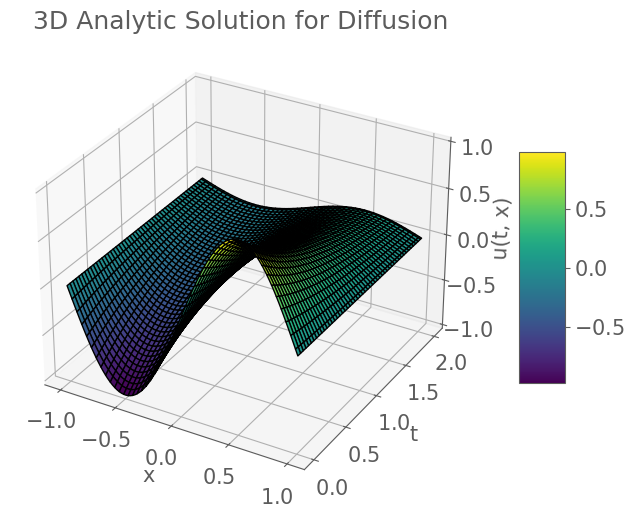

In [92]:
# Número de muestras para espacio y tiempo.
# Obs: Podrían tomarse distintos valores de muestreo en tiempo y en espacio, pero se considera un solo valor por simplicidad
dom_samples = 100

# Función para solución analítica
def analytic_diffusion(x,t):
    u = np.exp(-t)*np.sin(np.pi*x)
    return u

# Dominio espacial
x = np.linspace(-1, 1, dom_samples)
# Dominio temporal
t = np.linspace(0, 2, dom_samples)

# Mallado
X, T = np.meshgrid(x, t)
# Evaluar función en mallado
U = analytic_diffusion(X, T)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T, U, cmap='viridis', edgecolor='k')

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(t, x)')
ax.set_title('3D Analytic Solution for Diffusion')

# Añadir la barra de color
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()

In [93]:
# Correr animación y hacer display
anim = animate(x,t,U)
rc("animation", html="jshtml")
anim

## 2. Muestreo del Dominio para Entrenar con PINN
Para entrenar la PINN, vamos a muestrear el dominio usando la estrategia estratificada de Muestreo de Hipercubo Latino (*Latin Hypercube Sampling* - LHS). Este método asegura que se haga un muestreo que cubra uniformemente el espacio de entrada y evita la generación de aglomeraciones mediante la partición del dominio y la obtención aleatorizada de un punto por cada componente de la partición.

Importamos `qmc.LatinHypercube` desde `scipy.stats` y escalamos las muestras para que coincidan con los bordes del dominio. Adicionalmente, se convierten las observaciones y dominio temporal a `torch.tensors` para compatibilizarlos con el modelo de PINN.


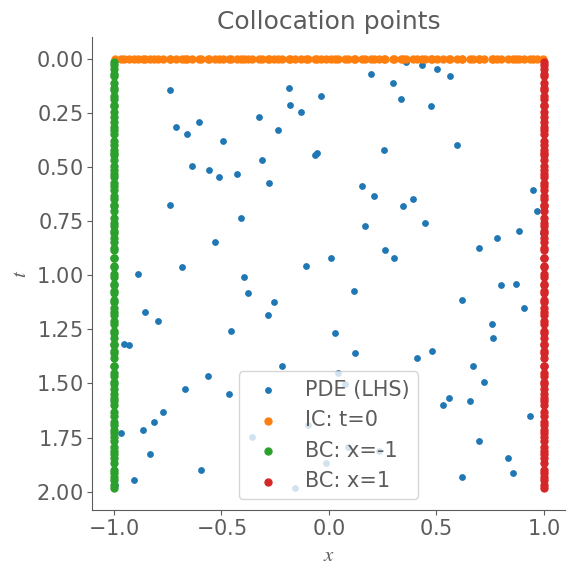

In [94]:
# Muestreo con LHS
def collocation_lhs(n=100, l_bounds=(-1, 0), u_bounds=(1, 2), plot=True):
    sampler = qmc.LatinHypercube(d=2)
    domain_xt = qmc.scale(sampler.random(n=n), l_bounds, u_bounds)

    # Interior (PDE)
    x_ten = torch.tensor(domain_xt[:, 0], requires_grad=True).float().view(-1, 1)
    t_ten = torch.tensor(domain_xt[:, 1], requires_grad=True).float().view(-1, 1)

    # Proyecciones desde los mismos puntos LHS
    x_ic, t_ic = domain_xt[:, 0], np.full(n, l_bounds[1])      # IC: t = t_min
    t_bc = domain_xt[:, 1]                                      # BC: usar los mismos t
    x_bcL, x_bcR = np.full(n, l_bounds[0]), np.full(n, u_bounds[0])  # x = x_min / x_max

    if plot:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.scatter(domain_xt[:, 0], domain_xt[:, 1], s=15, label='PDE (LHS)')
        ax.scatter(x_ic, t_ic, s=25, label=f'IC: t={l_bounds[1]} ')
        ax.scatter(x_bcL, t_bc, s=25, label=f'BC: x={l_bounds[0]} ')
        ax.scatter(x_bcR, t_bc, s=25, label=f'BC: x={u_bounds[0]} ')
        ax.set(title='Collocation points', xlabel=r'$x$', ylabel=r'$t$')
        ax.legend(loc='best'); ax.invert_yaxis()
        plt.tight_layout(); plt.show()

    return x_ten, t_ten

_ = collocation_lhs()

## 3. Entrenamiento de la PINN

En esta etapa se define una red neuronal que aproxima la solución de la ecuación diferencial mediante un modelo paramétrico. La función desconocida $u(t, x)$ se reemplaza por una red neuronal dependiente de un conjunto de parámetros $\Theta$:

$$
u_{pinn}(t, x; \Theta) \approx u(t,x)
$$

donde $\Theta$ son los parámetros entrenables de la red. Notar que para este caso, tenemos dos variables de entrada $t$ y $x$. Usamos `PyTorch` para crear la red neuronal y consideramos el optimizador ADAM.

In [95]:
# Definir clase de red neuronal con capas y neuronas especificadas por usuario
class NeuralNetwork(nn.Module):

    def __init__(self, hlayers):
        super(NeuralNetwork, self).__init__()

        layers = []
        for i in range(len(hlayers[:-2])):
            layers.append(nn.Linear(hlayers[i], hlayers[i+1]))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hlayers[-2], hlayers[-1]))

        self.layers = nn.Sequential(*layers)
        self.init_params()

    def init_params(self):
        """Inicialización de parámetros Xavier Glorot
        """
        def init_normal(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) # Xavier
        self.apply(init_normal)

    def forward(self, x):
        return self.layers(x)

## 4 y 5. Función de Pérdida Informada con Física (utilizando autodiff)

Para entrenar la PINN, definimos las funciones $f_{pde}(t, x)$, $g_{ic}(0)$ and $h_{bc}(0)$ asociadas a la EDP, la condición inicial y condición de borde, respectivamente. Además, reemplazamos la solución $u(t,x)$ por el output de la PINN $u_{pinn}(t,x; \Theta)$:
$$
\begin{align*}
f_{pde}(t,x;u_{pinn}):=& \frac{\partial u_{pinn}}{\partial t} - \frac{\partial^2 u_{pinn}}{\partial x^2} + e^{-t}(\sin(\pi x) - \pi^2 \sin(\pi x)) = 0\\
g_{ic}(0,x;u_{pinn}):=&u_{pinn}(0,x; \Theta) = \sin(\pi x)\\
h_{bc1}(t,-1;u_{pinn}):=&u_{pinn}(t,-1; \Theta) = 0\\
h_{bc2}(t,1;u_{pinn}):=&u_{pinn}(t,1; \Theta) = 0
\end{align*}
$$
Una vez más, consideramos el error cuadrático medio y definimos la función de pérdida con información de la física del modelo:

$$
\begin{align*}
\mathcal{L}(\theta):&= \frac{\lambda_1}{N}\sum_i\left(f_{pde}(t_i, x_i;u_{pinn})-0\right)^2 \quad \text{(Pérdida EDP)}\\
                   & + \frac{\lambda_2}{N} \sum_i(g_{ic}(0,x_i;u_{pinn})-\sin(\pi x_i))^2 \quad \text{(Pérdida CI)}\\
                   & + \frac{\lambda_3}{N} \sum_i(h_{bc1}(t_i,-1;u_{pinn})-0)^2 \quad \text{(Pérdida CB1)}\\
                   & + \frac{\lambda_3}{N} \sum_i(h_{bc2}(t_i,1;u_{pinn})-0)^2 \quad \text{(Pérdida CB2)}\\
\end{align*}
$$

donde $\lambda_{1,2,3}\in\mathbb{R}^+$ son valores de ponderación positivos y $N$ es el número de muestras.

El entrenamiento se realiza minimizando la función de pérdida $\mathcal{L}(\Theta)$:

$$
\min_{\Theta\in\mathbb{R}} \mathcal{L}(\Theta)\rightarrow 0
$$

utilizando diferenciación automática (`torch.autograd`) para calcular las derivadas de la red con respecto al tiempo, necesarias para evaluar el residuo físico del modelo.

> **💡 REMARK!:**  
> Cuando se incluye la función de datos en la pérdida, estamos empleando un esquema basado en datos (data-driven scheme). En caso contrario, decimos que estamos usando un esquema libre de datos (data-free scheme).

> **💡 REMARK!:**  
> Para la construcción de la función de pérdida necesitamos el autodiff, definido en la función auxiliar `grad`


In [96]:
# Error cuadrático medio (Mean Squared Error - MSE)
MSE_func = nn.MSELoss()

def PINN_diffusion_Loss(forward_pass, x_ten, t_ten, 
             lambda1 = 1, lambda2 = 1, lambda3 = 1):

    # ANN output, first and second derivatives
    domain = torch.cat([t_ten, x_ten], dim = 1)
    u = forward_pass(domain)
    u_t = grad(u, t_ten)
    u_x = grad(u, x_ten)
    u_xx = grad(u_x, x_ten)
    
    # PDE loss definition
    f_pde = u_t - u_xx + torch.exp(-t_ten)*(torch.sin(np.pi*x_ten)
                          -(torch.pi**2)*torch.sin(np.pi*x_ten))
    PDE_loss = lambda1 * MSE_func(f_pde, torch.zeros_like(f_pde)) 
    
    # IC loss definition
    ic = torch.cat([torch.zeros_like(t_ten), x_ten], dim = 1)
    g_ic = forward_pass(ic)
    IC_loss = lambda2 * MSE_func(g_ic, torch.sin(torch.pi*x_ten))

    # BC x = -1 definition
    bc1 = torch.cat([t_ten, -torch.ones_like(x_ten)], dim = 1)
    h_bc1 = forward_pass(bc1)
    BC1_loss = lambda3 * MSE_func(h_bc1, torch.zeros_like(h_bc1))
    
    # BC x = 1 definition
    bc2 = torch.cat([t_ten, torch.ones_like(x_ten)], dim = 1)
    h_bc2 = forward_pass(bc2)
    BC2_loss = lambda3 * MSE_func(h_bc2, torch.zeros_like(h_bc2))
    
    return PDE_loss + IC_loss + BC1_loss + BC2_loss



### 6. Definición del optimizador

Una vez definida la función de pérdida, se selecciona un optimizador para ajustar los parámetros $\Theta = \{W_i, b_i\}$ de la red neuronal. El objetivo del optimizador es minimizar la función de pérdida informada por la física, es decir:

$$
\min_{\Theta} \mathcal{L}(\Theta) \quad \text{via} \quad \Theta^{k+1}=\Theta^{k}-\alpha\nabla_\Theta\mathcal{L}(\Theta^{k})
$$

En esta etapa se emplea el optimizador **ADAM**.

In [97]:
def pinn_optimizer(pinn, lr = 0.01):

    # Define an optimizer (Adam) for training the network
    return optim.Adam(pinn.parameters(), lr=lr,
                        betas= (0.99,0.999), eps = 1e-8)

### Ciclo de entrenamiento

En esta etapa se ejecuta el proceso iterativo mediante el cual la PINN ajusta sus parámetros $\Theta = \{W_i, b_i\}$ para minimizar la función de pérdida definida anteriormente. Durante cada época (*epoch*), el modelo evalúa el residuo del modelo PDE sobre los puntos de colocación $(t_i,x_i) \in [0, 2]\times [-1,1]$, actualizando los parámetros según el gradiente de la pérdida:

$$
\Theta \leftarrow \Theta - \eta \, \nabla_\Theta \mathcal{L}(\Theta)
$$

donde $\eta$ es la tasa de aprendizaje.

A continuación se presenta el código completo:

In [98]:
#===============================================================================
# ETAPA 1: DEFINICIÓN DE LOS PARÁMETROS (MODELO FÍSICO)
#===============================================================================
# Límites del dominio
l_bounds = [-1, 0]
u_bounds = [ 1, 2]

Ncoll_points = 100

#===============================================================================
# ETAPA 2: DEFINICIÓN DEL DOMINIO 
#===============================================================================
x_ten, t_ten = collocation_lhs(Ncoll_points, l_bounds, u_bounds, False)

#===============================================================================
# ETAPA 3: CREACIÓN DE LA RED NEURONAL SURROGANTE 
#===============================================================================
torch.manual_seed(123)

# hiper-parámetros de la red
hidden_layers = [2, 10, 10, 10, 1]

# Crear instancia de la NN
u_pinn = NeuralNetwork(hidden_layers)
nparams = sum(p.numel() for p in u_pinn.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {nparams}')


#===============================================================================
# ETAPA 4 Y 5: DEFINICIÓN DE LA FUNCIÓN DE COSTO BASADA EN AUTOGRAD
#===============================================================================
# Error cuadrático medio (Mean Squared Error - MSE)
MSE_func = nn.MSELoss()

def PINN_diffusion_Loss(forward_pass, x_ten, t_ten, 
             lambda1 = 1, lambda2 = 1, lambda3 = 1):

    # ANN output, first and second derivatives
    domain = torch.cat([t_ten, x_ten], dim = 1)
    u = forward_pass(domain)
    u_t = grad(u, t_ten)
    u_x = grad(u, x_ten)
    u_xx = grad(u_x, x_ten)
    
    # PDE loss definition
    f_pde = u_t - u_xx + torch.exp(-t_ten)*(torch.sin(np.pi*x_ten)
                          -(torch.pi**2)*torch.sin(np.pi*x_ten))
    PDE_loss = lambda1 * MSE_func(f_pde, torch.zeros_like(f_pde)) 
    
    # IC loss definition
    ic = torch.cat([torch.zeros_like(t_ten), x_ten], dim = 1)
    g_ic = forward_pass(ic)
    IC_loss = lambda2 * MSE_func(g_ic, torch.sin(torch.pi*x_ten))

    # BC x = -1 definition
    bc1 = torch.cat([t_ten, -torch.ones_like(x_ten)], dim = 1)
    h_bc1 = forward_pass(bc1)
    BC1_loss = lambda3 * MSE_func(h_bc1, torch.zeros_like(h_bc1))
    
    # BC x = 1 definition
    bc2 = torch.cat([t_ten, torch.ones_like(x_ten)], dim = 1)
    h_bc2 = forward_pass(bc2)
    BC2_loss = lambda3 * MSE_func(h_bc2, torch.zeros_like(h_bc2))
    
    return PDE_loss + IC_loss + BC1_loss + BC2_loss

#===============================================================================
# ETAPA 6: DEFINICIÓN DEl OPTIMIZADOR
#===============================================================================
lr = 0.001
optimizer = pinn_optimizer(u_pinn, lr)


#===============================================================================
# CICLO DE ENTRENAMIENTO
#===============================================================================
training_iter = 20000

# Inicializar lista para guardar valores de pérdida
loss_values = []

# Empezar timer
start_time = time.time()

# Entrenar red neuronal
for i in range(training_iter):

    optimizer.zero_grad()   # Reinicializar gradientes para iteración de entrenamiento

    # ingresar x, predecir con PINN y obtener pérdida
    loss = PINN_diffusion_Loss(u_pinn, x_ten, t_ten)

    # Agregar actual valor de pérdida a la lista
    loss_values.append(loss.item())

    if i % 1000 == 0:  # Print cada 1000 iteraciones
        print(f"Iteration {i}: Loss {loss.item()}")

    loss.backward() # Paso de retropropagación
    optimizer.step() # Actualizar pesos de la red con optimizador

# Detener timer y obtener tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

Number of trainable parameters: 261
Iteration 0: Loss 11.090126037597656
Iteration 1000: Loss 0.033761125057935715
Iteration 2000: Loss 0.01062633004039526
Iteration 3000: Loss 0.006061647552996874
Iteration 4000: Loss 0.00257642543874681
Iteration 5000: Loss 0.001280647935345769
Iteration 6000: Loss 0.0006927236099727452
Iteration 7000: Loss 0.0003782280255109072
Iteration 8000: Loss 0.00019725950551219285
Iteration 9000: Loss 0.00011081273260060698
Iteration 10000: Loss 6.728671723976731e-05
Iteration 11000: Loss 4.15281429013703e-05
Iteration 12000: Loss 2.5728817490744404e-05
Iteration 13000: Loss 1.647387762204744e-05
Iteration 14000: Loss 1.1076887858507689e-05
Iteration 15000: Loss 8.049457392189652e-06
Iteration 16000: Loss 6.281366950133815e-06
Iteration 17000: Loss 5.097665507491911e-06
Iteration 18000: Loss 4.337600330472924e-06
Iteration 19000: Loss 3.876269602187676e-06
Training time: 34.00617170333862 seconds


Relative error: 0.0013588160509243608


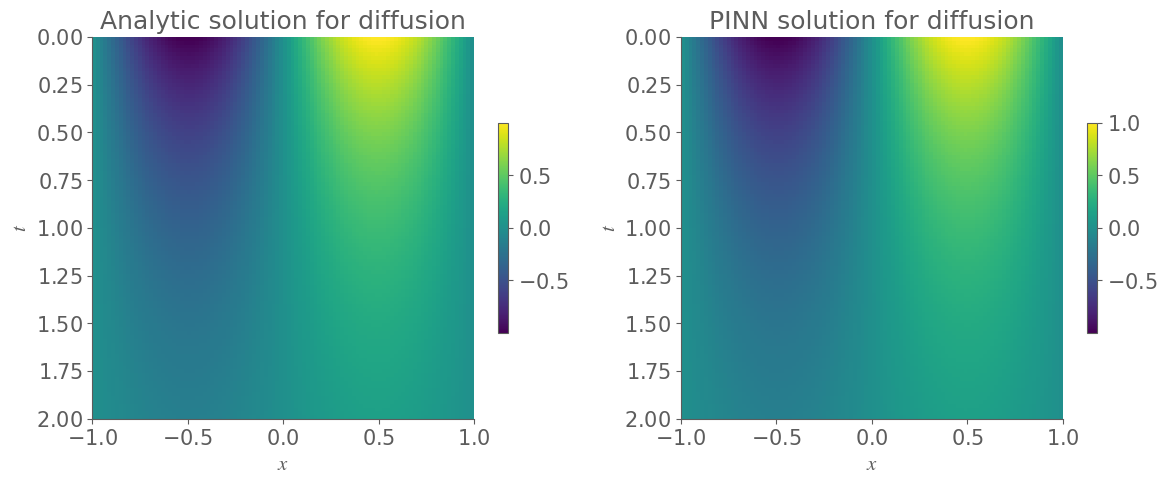

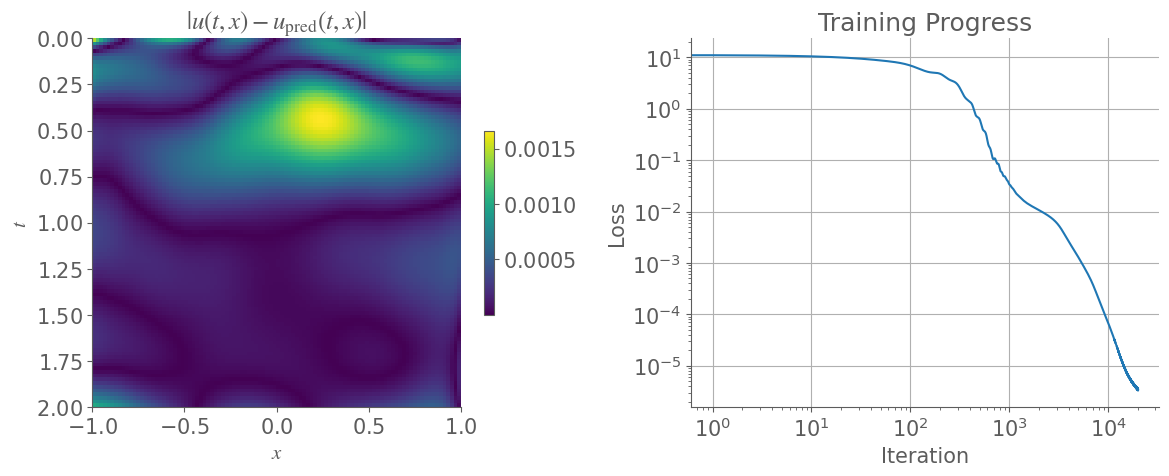

In [99]:
# Graficación
X_ten = torch.tensor(X).float().reshape(-1, 1)
T_ten = torch.tensor(T).float().reshape(-1, 1)
domain_ten = torch.cat([T_ten, X_ten], dim = 1)
U_pred = u_pinn(domain_ten).reshape(dom_samples,dom_samples)

U_true = torch.tensor(U).float()
print(f'Relative error: {relative_l2_error(U_pred, U_true)}')

plot_comparison(U, U_pred, loss_values)

## **Ejercicios**:
1. Agregar caso basado en datos. **Indicación**: Utilice los mismos puntos de colocación de la PINN.
2. Evalúe cómo varía la solución de la PINN aumentando y disminuyendo los pesos `lambdas`.
3. Evalúe cómo varía la solución de la PINN aumentando y disminuyendo la tasa de aprendizaje y el número de iteraciones de entrenamiento.
4. Cambie el número de capas ocultas, neuronas y funciones de activación del modelo de NN.

## **Questions**:
1. ¿Por qué no es necesario incluir datos de la solución en el interior del dominio para resolver el problema de EDP con PINNs?
   <details>
   <summary>Answer</summary>
    En el modelo de difusión, las leyes físicas son bien comprendidas y el problema asociado es bien puesto. El modelo de calor describe cómo una cantidad de interés cambia con el tiempo y cómo esta dinámica se relaciona con el espacio. Las propiedades de los operadores lineales asociados a la EDP de calor hacen que las soluciones al problema de difusión sean únicas y estables, siendo solamente necesarias las condiciones iniciales y de borde para conocerlas completamente al interior del dominio. Este comportamiento hace que no sea necesario tomar un enfoque basado en datos para conocer la solución del problema de difusión, haciendo que la PINN pueda prescindir de información empírica y solo tenga que minimizar residuos asociados a la formulación matemática de la EDP.
   </details>

